### 4 main topics regarding using chains in langgraph:
- how to use chat messages as graph state 
- how to use chat models in graph nodes
- how to bind tools to LLM
- how to execute the tool calls

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

## Messages
4 types - system, human, ai , tool

every message has:
- content
- name
- response_metadata

In [2]:
#manual messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can i help you today?",
                      name= "LLMModel")]

messages.append(HumanMessage(content="I want to build a house", nane="Soham"))
messages.append(AIMessage(content="Sure! What type of house do you want?", name="LLMModel"))
messages.append(HumanMessage(content="A big one with 4 bedrooms", name="Soham"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can i help you today?
================================ Human Message =================================

I want to build a house
================================== Ai Message ==================================
Name: LLMModel

Sure! What type of house do you want?
================================ Human Message =================================
Name: Soham

A big one with 4 bedrooms


## Chat Models

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")
llm

c:\dev\AgenticAI_Material\langgraph_tut\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001A773C9F990>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A773E06BD0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
llm.invoke([HumanMessage(content="Explain the theory of relativity in simple terms.")])

AIMessage(content='<think>\nOkay, so I need to explain the theory of relativity in simple terms. Hmm, where to start? I remember there are two parts: special relativity and general relativity. Let me break them down one by one.\n\nFirst, special relativity. I think it\'s about how the laws of physics are the same for all non-accelerating observers. Oh, and it also deals with the speed of light being constant, right? So no matter how fast you\'re moving, light always seems to travel at the same speed. That leads to some weird effects like time dilation and length contraction. Time dilation means that time can slow down for someone moving close to the speed of light compared to someone who\'s stationary. Like if you had a twin who went off in a spaceship at a huge speed, they\'d age more slowly than you on Earth. Cool, but how does that work?\n\nThen there\'s the concept of mass increasing as you approach the speed of light. So if you were to get close to the speed of light, your mass wo

In [5]:
result = llm.invoke(messages)


In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 965,
  'prompt_tokens': 61,
  'total_tokens': 1026,
  'completion_time': 8.498523632,
  'completion_tokens_details': None,
  'prompt_time': 0.002238955,
  'prompt_tokens_details': None,
  'queue_time': 0.158433165,
  'total_time': 8.500762587},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_2bfcc54d36',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

## Tools

In [7]:
#some tool
def add(a: int, b:int)->int:
    """Add the numbers
    args:
        a: first number
        b: second number
        
        c: sum of a and b
        
    returns: c
    
    """
    return a+b

In [8]:
llm_with_tool = llm.bind_tools([add])
response= llm_with_tool.invoke([
    HumanMessage(content="What is 1+2")])

In [9]:
# Note how the llm does a tool call
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is 1+2". Let me see. I need to use the add function provided. The function takes two integers, a and b. So, a is 1 and b is 2 here. I should call the add function with these values. The sum should be 3. Let me make sure the parameters are correct. Yep, both are integers. Alright, I\'ll generate the tool call with a=1 and b=2.\n', 'tool_calls': [{'id': 'ssht3m943', 'function': {'arguments': '{"a":1,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 128, 'prompt_tokens': 186, 'total_tokens': 314, 'completion_time': 0.208255995, 'completion_tokens_details': {'reasoning_tokens': 99}, 'prompt_time': 0.008829971, 'prompt_tokens_details': None, 'queue_time': 0.056716673, 'total_time': 0.217085966}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'mo

In [10]:
from pydantic import BaseModel
from langgraph.graph.message import add_messages #Reducer to add message
from langgraph.graph import StateGraph
from langchain_core.messages import AnyMessage #Generic message type
from typing import Annotated
from typing_extensions import TypedDict
#note: without reducer, the state will not append messages, instead it will override the older one.

#creating the state schema
class ChatState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 
    name: str       

showcasing reducers

In [11]:
# Work of reducers: add_message

initial_message = [HumanMessage(content="Hello, I want to learn coding", name="Soham")]
ai_message = [AIMessage(content="Sure! What language do you want to learn?", name="LLMModel")]

reducer_result = add_messages(initial_message, ai_message)
print(reducer_result) 

[HumanMessage(content='Hello, I want to learn coding', additional_kwargs={}, response_metadata={}, name='Soham', id='2a8e98f0-8a9f-4d57-b279-1a3e701a6952'), AIMessage(content='Sure! What language do you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='356bdb83-c659-4ed7-a429-8b1583b943ab', tool_calls=[], invalid_tool_calls=[])]


back to llm, tools, and creating graphs|

In [12]:
# Creatin node

#chatbot node mfunctionality    
def llm_tool(state: ChatState):
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

In [13]:
from langgraph.graph import START, END

graph= StateGraph(ChatState)
graph.add_node("llm_tool", llm_tool)

graph.add_edge(START, "llm_tool")
graph.add_edge("llm_tool", END)    

graph = graph.compile()
 

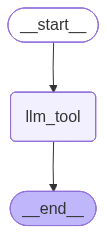

In [14]:
graph

In [ ]:
from pprint import pprin t

messages = graph.invoke({"messages": "What is 2 plus 2"})

for message in messages["messages"]:
    print(message)

content='What is 2 plus 2' additional_kwargs={} response_metadata={} id='3883565a-7251-42b8-8e43-217accfc91b0'
content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is 2 plus 2". Let me see. I need to use the add function provided. The function requires two integers, a and b. The user is adding 2 and 2, so I should call the add function with a=2 and b=2. That should return the sum, which is 4. I need to make sure the JSON is correctly formatted with the function name and arguments.\n', 'tool_calls': [{'id': '12yhp658s', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 187, 'total_tokens': 308, 'completion_time': 0.190937537, 'completion_tokens_details': {'reasoning_tokens': 92}, 'prompt_time': 0.008129843, 'prompt_tokens_details': None, 'queue_time': 0.056078171, 'total_time': 0.19906738}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5c